In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neural_network import MLPClassifier

from lightgbm import LGBMClassifier

## Data Setup

In [2]:
df_heart = pd.read_csv('https://tinyurl.com/heartdiseaseprocessed')
df_heart_num = pd.read_csv('https://tinyurl.com/heartdiseaseprocessednumeric')

# convert appropriate features to categorical
for col in df_heart.select_dtypes(include='object').columns:
    df_heart[col] = df_heart[col].astype('category')

X = df_heart_num.drop(columns=['heart_disease']).to_numpy()
y = df_heart_num['heart_disease'].to_numpy()

In [3]:
prevalence = np.mean(y)
majority = np.max([prevalence, 1 - prevalence])

## Penalized Linear Models/Elastic Net

In [4]:
model_elastic = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    random_state=42,
    max_iter=10000,
    verbose=False,
)

# use cross-validation to estimate performance
cv_elastic = cross_validate(
    model_elastic,
    X,
    y,
    cv=5,
    scoring='accuracy',
)

In [5]:
print(
    'Training accuracy: ',
    np.round(cv_elastic['test_score'].mean(), 3),
    '\nGuessing: ',
    np.round(majority, 3),
)

Training accuracy:  0.828 
Guessing:  0.539


## Tree-based Models

In [6]:
model_boost = LGBMClassifier(
    n_estimators = 1000,
    learning_rate = 1e-3,
    max_depth = 5,
    verbose = -1,
    random_state=42,
)

model_boost_cv = cross_validate(
    model_boost,
    df_heart.drop(columns='heart_disease'),
    df_heart['heart_disease'],
    cv = 5,
    scoring='accuracy',
)

In [7]:
print(
    'Training accuracy: ',
    np.round(np.mean(model_boost_cv['test_score']), 3),
    '\nGuessing: ',
    np.round(majority, 3),
)

Training accuracy:  0.835 
Guessing:  0.539


## Deep Learning Example

In [8]:
model_mlp = MLPClassifier(
    hidden_layer_sizes = (200, 200, 200),  
    learning_rate = 'adaptive',
    learning_rate_init = 0.001,
    shuffle = True,
    random_state = 123,
    warm_start = True,
    nesterovs_momentum = True,
    validation_fraction =  .2,
    verbose = False,
)

# with the above settings, this will take a few seconds
model_mlp_cv = cross_validate(
    model_mlp, 
    X, 
    y, 
    cv = 5
) 

In [9]:
print(
    'Training accuracy: ',
    np.round(np.mean(model_mlp_cv['test_score']), 3),
    '\nGuessing: ',
    np.round(majority, 3),
)

Training accuracy:  0.818 
Guessing:  0.539


## A Tuned Example

In [10]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df_heart.drop(columns='heart_disease'), 
    df_heart_num['heart_disease'],
    test_size = 0.2,
    random_state = 42
)

model_boost = LGBMClassifier(
    verbose = -1
)

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [1e-3, 1e-2, 1e-1],
    'max_depth': [3, 5, 7, 9],
    'min_child_samples': [1, 5, 10],
}

# this will take a few seconds
model_boost_cv_tune = RandomizedSearchCV(
    model_boost, 
    param_grid, 
    n_iter = 10,
    cv = 5, 
    scoring = 'accuracy', 
    n_jobs = -1,
    random_state = 42
)

model_boost_cv_tune.fit(X_train, y_train)

test_predictions = model_boost_cv_tune.predict(X_test)
accuracy_score(y_test, test_predictions)

0.8

## Comparing Models

This may take a couple minutes to run, mostly because of the MLP model.

In [11]:
seed = 42

def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = accuracy_score(y_true, y_pred)
    tpr = recall_score(y_true, y_pred)  # True Positive Rate (Sensitivity)
    tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
    f1 = f1_score(y_true, y_pred)
    ppv = precision_score(y_true, y_pred)  # Positive Predictive Value (Precision)
    npv = tn / (tn + fn)  # Negative Predictive Value
    return {
        'acc': acc,
        'tpr': tpr,
        'tnr': tnr,
        'f1': f1,
        'ppv': ppv,
        'npv': npv
    }

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return calculate_metrics(y_test, y_pred)


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Define models
model_glmnet = LogisticRegression(solver='saga', max_iter=10000, random_state=seed)
model_boost = LGBMClassifier(random_state=seed, verbosity=-1)
model_mlp = MLPClassifier(
    learning_rate = 'adaptive',
    learning_rate_init = 0.001,
    shuffle = True,
    warm_start = True,
    nesterovs_momentum = True,
    validation_fraction =  .2,
    verbose = False,
    max_iter=10000,
    random_state=seed
)

# Define parameter space for each model
param_glmnet = {
    'penalty': ['elasticnet'],
    'l1_ratio': [0.1, 0.5, 0.9],
    'C': [0.01, 0.1, 1, 10]
}

param_boost = {
    'n_estimators': [250, 500],
    'learning_rate': [1e-3, 0.01, 0.1, 0.5],
    'max_depth': [2, 3, 5, 7],
    'min_child_samples': [1, 5, 10, 50],
    'colsample_bytree': [0.75, 1.0],
    'reg_alpha': [0.0, 1],
    'reg_lambda': [0.0, 1]
}

param_mlp = {
    'hidden_layer_sizes': [(100, 100), (200, 200), (100, 100, 100), (200, 200, 200)],
    'alpha': [0.0001, 0.001, 0.01]
}

# Perform hyperparameter tuning
search_glmnet = RandomizedSearchCV(
    model_glmnet, param_glmnet, cv=10, scoring='accuracy', random_state=seed
)
search_boost = RandomizedSearchCV(
    model_boost, param_boost, cv=10, scoring='accuracy', random_state=seed
)
search_mlp = RandomizedSearchCV(
    model_mlp, param_mlp, cv=10, scoring='accuracy', random_state=seed
)

# Fit the grid searches
search_glmnet.fit(X_train, y_train)
search_boost.fit(X_train, y_train)
search_mlp.fit(X_train, y_train)

# Get the best models
best_glmnet = search_glmnet.best_estimator_
best_boost = search_boost.best_estimator_
best_mlp = search_mlp.best_estimator_

In [12]:
# Evaluate the best models on the test set
results_glmnet = evaluate_model(best_glmnet, X_train, y_train, X_test, y_test)
results_boost = evaluate_model(best_boost, X_train, y_train, X_test, y_test)
results_mlp = evaluate_model(best_mlp, X_train, y_train, X_test, y_test)

# Aggregate results into a DataFrame for comparison
results_df = pd.DataFrame({
    'GLMNet': results_glmnet,
    'Boost': results_boost,
    'MLP': results_mlp
})

results = results_df.T.reset_index().rename(columns={'index': 'model'})

In [13]:
results

,model,acc,tpr,tnr,f1,ppv,npv
0,GLMNet,0.883333,0.833333,0.916667,0.851064,0.869565,0.891892
1,Boost,0.850000,0.916667,0.805556,0.830189,0.758621,0.935484
2,MLP,0.800000,0.833333,0.777778,0.769231,0.714286,0.875000


In [14]:
# Make predictions on the test set
y_pred_glmnet = best_glmnet.predict(X_test)
y_pred_boost = best_boost.predict(X_test)
y_pred_mlp = best_mlp.predict(X_test)

# Combine predictions with observed values into a DataFrame
df_predictions = pd.DataFrame({
    'Observed': y_test,
    'GLMNet_Predictions': y_pred_glmnet,
    'Boost_Predictions': y_pred_boost,
    'MLP_Predictions': y_pred_mlp
})


## Interpretation and Feature Importance

In [15]:
best_model = model_boost_cv_tune.best_estimator_
best_model.feature_importances_

# you remember which feature is which, right? if not, do this:
pd.DataFrame({
    'Feature': best_model.feature_name_,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

,Feature,Importance
0,age,526
4,cholesterol,513
7,max_heart_rate,437
3,resting_bp,364
9,st_depression,322
11,num_major_vessels,225
12,thalassemia,156
1,male,106
6,resting_ecg,106
5,fasting_blood_sugar,94


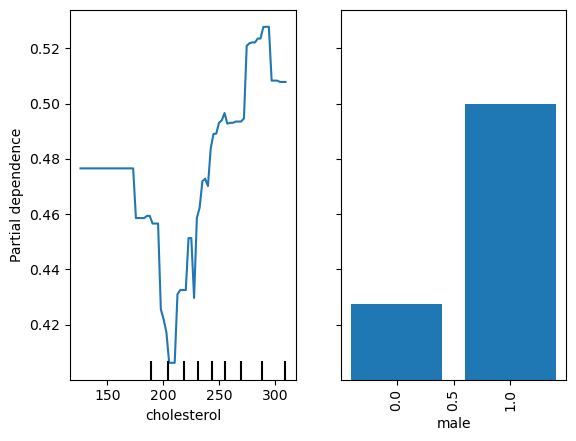

In [16]:
PartialDependenceDisplay.from_estimator(
    model_boost_cv_tune, 
    df_heart.drop(columns='heart_disease'), 
    features=['cholesterol', 'male'], 
    categorical_features=['male'], 
    percentiles=(0, .9),
    grid_resolution=75
)